# Apply structures

The purpose of this lesson is to familiarize you to coding with apply structures in R.

It is well known in the R programming community that for-loops are slow in R. As an example lets try get a sum each row of a random `data.frame` with four columns:

In [78]:
nrows = 100
data <- data.frame(
    var1=rnorm(nrows),
    var2=rnorm(nrows),
    var3=rnorm(nrows),
    var4=rnorm(nrows)
    )

Lets create a simple function `rowSums_forloop` that initializes a result vector `rowsum` and in a for-loop goes through the rows of the input `data.frame` and stores the sum of row `i` to the `rowsum[i]`:

In [79]:
rowSums_forloop <- function (dataframe) {
    # Sums up each row with inefficient for-loop
    # 
    # Args:
    #   dataframe: data.frame to sum over
    #
    # Returns:
    #   rowsum: Vector containing sum of each row
    
    # Generate the vector rowsum
    rowsum <- c()
    for (i in 1:nrow(dataframe)) {
        # For each row store the sum of row i to rowsum[i]
        rowsum[i] <- sum(dataframe[i,])
    }
    return(rowsum)
}

rowsum_forloop <- rowSums_forloop(data)
head(rowsum_forloop)

[1] -0.8660992 -0.8688562 -1.1071734 -1.6101365  3.2716871 -0.8522359

The previous way is not optimal as it does not utilize the vectorized nature of R.

Vectorized in this context means that as each column of `data` is a vector, `data[i,]` and `data[i+1,]` do not differ in structure. Thus sometimes the operation that is carried out on these rows (here it was the `sum`-function) can be done in parallel across multiple rows at a same time.

To utilize the vectorized nature of R objects one usually uses `apply`-style functions.

The basic `apply`-function has a simple syntax (see: [[1]](https://www.rdocumentation.org/packages/base/versions/3.4.3/topics/apply)):

```r
apply(array, margin, func)
```

Here `array` is a data array (vector, matrix, data.frame); `margin` is a integer/vector that determines whether to apply the function on rows (`1`), columns(`2`) or both (`c(1,2)`); and `func` is the function to apply.

Dimensions of the result depend on the dimensions of the original data, the direction of application and the output shape of `func`. In this case we want to apply the `sum` function to each row. `sum` returns a single number as a result, so the result size is a vector with `nrows`.

In [80]:
rowSums_apply <- function(dataframe) {
    # Sums up each row with an apply-function call
    # 
    # Args:
    #   dataframe: data.frame to sum over
    #
    # Returns:
    #   rowsum: Vector containing sum of each row
    # 
    
    # Apply sum-function to each row of dataframe and return the result
    rowsum <- apply(dataframe,1,sum)
    return(rowsum)
}
rowsum_apply <- rowSums_apply(data)

# Check that results match
head(rowsum_apply)
all.equal(rowsum_forloop,rowsum_apply)

[1] -0.8660992 -0.8688562 -1.1071734 -1.6101365  3.2716871 -0.8522359

[1] TRUE

Of course a language like R has an internal function for calculating the sum of columns for each row. This function is `rowSums`.

In [81]:
rowsum_baser <- rowSums(data)

# Check that results match
head(rowsum_baser)
all.equal(rowsum_apply, rowsum_baser)


[1] -0.8660992 -0.8688562 -1.1071734 -1.6101365  3.2716871 -0.8522359

[1] TRUE

Now that we have three implementations of the same function we can use `microbenchmark`-library to make them compete against each other. `microbenchmark`-function can be used to run a function call in order to generate statistics of the function runtime. By default it runs the code 100 times.

In [82]:
library(microbenchmark)

print(microbenchmark(
    rowSums_forloop(data),
    rowSums_apply(data),
    rowSums(data)
))

Unit: microseconds
                  expr      min        lq       mean    median        uq
 rowSums_forloop(data) 5690.796 6018.7460 6385.70329 6094.1665 6194.7945
   rowSums_apply(data)  129.811  139.6985  157.35065  142.4565  146.6795
         rowSums(data)   25.706   28.8150   31.68336   30.7610   32.8335
      max neval
 8755.725   100
 1384.070   100
   83.475   100


As is apparent from the runtimes the for-loop implementation loses by a huge margin. In general it is good to avoid for-loops unless there is a sequential order to the looping e.g. for-loop an iterative algorithm.

year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
2013,1,1,517,515,2,830,819,11,UA,1545,N14228,EWR,IAH,227,1400,5,15,2013-01-01 05:00:00
2013,1,1,533,529,4,850,830,20,UA,1714,N24211,LGA,IAH,227,1416,5,29,2013-01-01 05:00:00
2013,1,1,542,540,2,923,850,33,AA,1141,N619AA,JFK,MIA,160,1089,5,40,2013-01-01 05:00:00
2013,1,1,544,545,-1,1004,1022,-18,B6,725,N804JB,JFK,BQN,183,1576,5,45,2013-01-01 05:00:00
2013,1,1,554,600,-6,812,837,-25,DL,461,N668DN,LGA,ATL,116,762,6,0,2013-01-01 06:00:00
2013,1,1,554,558,-4,740,728,12,UA,1696,N39463,EWR,ORD,150,719,5,58,2013-01-01 05:00:00


[1] 336776

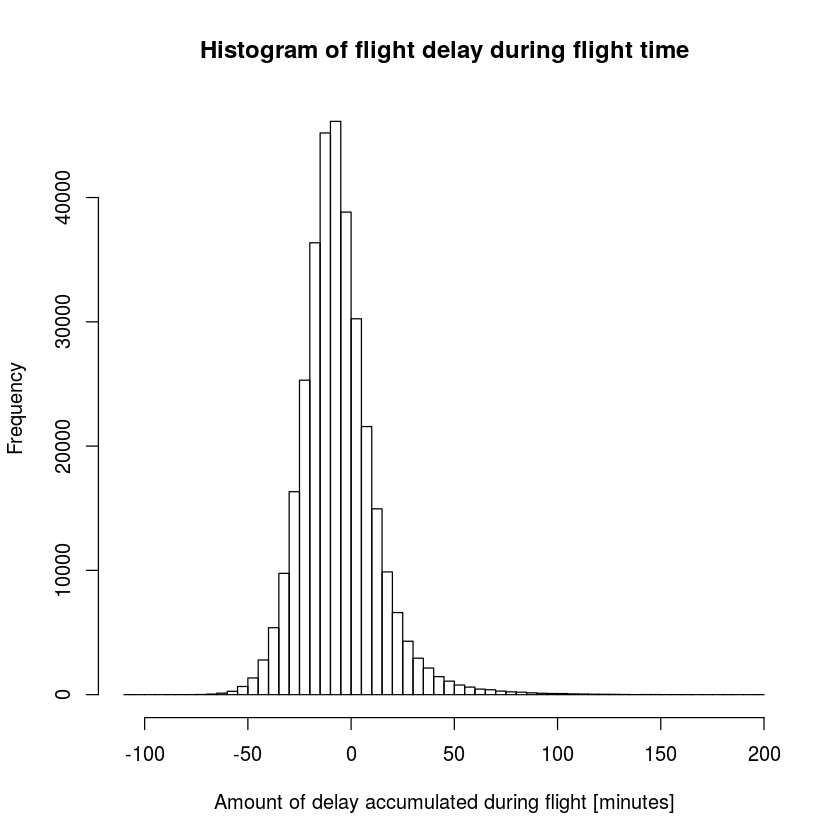

In [119]:
library(nycflights13)
head(flights)
nrow(flights)

flighttimedelay_noapply <- function(dataframe) {
    return(flights$arr_delay - flights$dep_delay)
}

ftd_noapply <- flighttimedelay_noapply(flights)
                  
hist(ftd_noapply,breaks=50,plot=T,main='Histogram of flight delay during flight time',xlab='Amount of delay accumulated during flight [minutes]')

In [120]:
flighttimedelay_mapply <- function(dataframe) {
    return(mapply(function(x,y) x-y,flights['arr_delay'],flights['dep_delay']))
}

ftd_mapply <- flighttimedelay_mapply(flights)
                  
# Do note that the result is a matrix, not a vector
class(ftd_noapply)
length(ftd_noapply)
class(ftd_mapply) 
dim(ftd_mapply)
                  
ftd_mapply <- c(ftd_mapply)

class(ftd_mapply) 
length(ftd_mapply)

all.equal(ftd_noapply,ftd_mapply)

[1] "numeric"

[1] 336776

[1] "matrix"

[1] 336776      1

[1] "numeric"

[1] 336776

[1] TRUE

In [121]:
library(parallel)

flighttimedelay_mcmapply <- function(dataframe) {
    return(mcmapply(function(x,y) x-y,flights['arr_delay'],flights['dep_delay'],mc.cores=8))
}

ftd_mcmapply <- flighttimedelay_mcmapply(flights)
                  
ftd_mcmapply <- c(ftd_mcmapply)

all.equal(ftd_noapply,ftd_mcmapply)

[1] TRUE

In [118]:
print(microbenchmark(
    flighttimedelay_noapply(flights),
    flighttimedelay_mapply(flights),
    flighttimedelay_mcmapply(flights)
))

Unit: microseconds
                              expr      min        lq      mean    median
  flighttimedelay_noapply(flights)  275.739  474.4805  571.8502  504.6735
   flighttimedelay_mapply(flights) 1671.309 1870.6445 2239.1460 1982.0490
 flighttimedelay_mcmapply(flights) 1700.173 1931.5640 2424.2743 2001.5530
       uq      max neval
  538.682 2762.096   100
 2079.828 4787.532   100
 2212.890 5511.984   100
